In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
from sklearn.cluster import Birch
import matplotlib.pyplot as plt

In [ ]:
uploaded = files.upload()

Saving yellow_tripdata_2024-09.parquet to yellow_tripdata_2024-09 (1).parquet


The following code reads a Parquet file containing taxi trip data and preprocesses it for clustering analysis. It begins by setting a display option to show all columns in the DataFrame. The path to the Parquet file is specified, and the file is read into a DataFrame using pandas. The code then selects relevant numerical features, specifically trip_distance and fare_amount, and removes any rows with missing values. To handle extreme outliers, the code calculates the interquartile range (IQR) and filters out rows where the values of the selected features fall outside 1.5 times the IQR from the first and third quartiles. After cleaning the data, the code normalizes the selected features using Min-Max normalization, which scales the values to a range between 0 and 1. The normalized features are stored in a new DataFrame, ready for further analysis or clustering.

In [ ]:
# Set display option to show all columns
pd.set_option('display.max_columns', None)

# Path to the Parquet file
file_path = 'yellow_tripdata_2024-09.parquet'

# Read the Parquet file into a DataFrame
df = pd.read_parquet(file_path)

# Select relevant numerical features
selected_features = df[['trip_distance', 'fare_amount']]

# Remove missing values
selected_features = selected_features.dropna()

# Remove extreme outliers using IQR method
Q1 = selected_features.quantile(0.25)
Q3 = selected_features.quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
filtered_features = selected_features[~((selected_features < (Q1 - 1.5 * IQR)) | (selected_features > (Q3 + 1.5 * IQR))).any(axis=1)]

# Normalize the data using Min-Max normalization
scaler = MinMaxScaler()
normalized_features = pd.DataFrame(scaler.fit_transform(filtered_features), columns=filtered_features.columns)

# Display the first few rows of the normalized features DataFrame
print(normalized_features.head())

   trip_distance  fare_amount
0       0.069444       0.3000
1       0.318056       0.4500
2       0.722222       0.6500
3       0.313889       0.5125
4       0.166667       0.3625


The following code experiments with different configurations of the Birch clustering algorithm to segment the preprocessed taxi trip data into clusters. It defines two configurations with varying values for the branching_factor and threshold parameters. The branching_factor controls the maximum number of CF subclusters in a node, while the threshold defines the maximum radius of subclusters.

For each configuration, the code initializes a Birch model with the specified parameters and fits it to the normalized features. The resulting cluster labels are added to the DataFrame with a column name indicating the configuration used. The code then visualizes the clustering results by creating scatter plots of trip_distance versus fare_amount, with different colors representing different clusters. The plots are displayed with titles and labels to indicate the configuration parameters used for each clustering. This allows for a visual comparison of how different branching_factor and threshold values affect the clustering results.

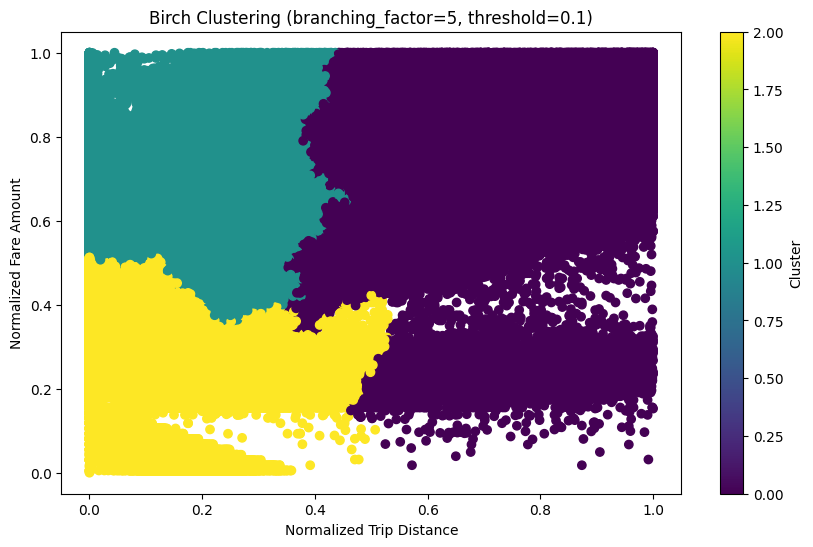

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (3). Decrease the threshold.
  warnings.warn(


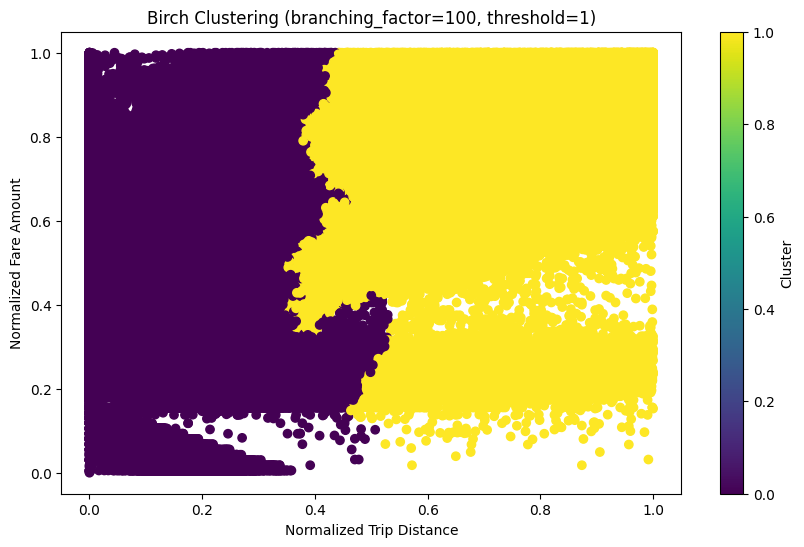

In [ ]:
# Experiment with different values of branching_factor and threshold
configurations = [
    {'branching_factor': 5, 'threshold': 0.1},
    {'branching_factor': 100, 'threshold': 1}
]

for config in configurations:
    # Apply the Birch clustering algorithm with the current configuration
    birch_model = Birch(n_clusters=3, branching_factor=config['branching_factor'], threshold=config['threshold'])
    clusters = birch_model.fit_predict(normalized_features)

    # Add the cluster labels to the DataFrame
    normalized_features[f'cluster_{config["branching_factor"]}_{config["threshold"]}'] = clusters

    # Visualize the clustering results
    plt.figure(figsize=(10, 6))
    plt.scatter(normalized_features['trip_distance'], normalized_features['fare_amount'], c=clusters, cmap='viridis', marker='o')
    plt.title(f'Birch Clustering (branching_factor={config["branching_factor"]}, threshold={config["threshold"]})')
    plt.xlabel('Normalized Trip Distance')
    plt.ylabel('Normalized Fare Amount')
    plt.colorbar(label='Cluster')
    plt.show()

**Plot 1: (branching_factor=5, threshold=0.1)**

This plot shows three distinct clusters:

Dark Purple Cluster: This cluster represents a large portion of the data points concentrated in the higher normalized trip distance and fare amount. These likely represent longer trips with higher fares.

Teal/Green Cluster: This cluster is situated at the lower end of normalized trip distance, but has a broader range in normalized fare amount. It likely represents shorter trips, with fare amounts ranging more than the other clusters.

Yellow Cluster: This is a smaller cluster at lower normalized trip distances and lower normalized fare amounts. These are likely very short and inexpensive trips.

**Plot 2: (branching_factor=100, threshold=1)**

This plot reveals a simpler clustering structure with just two main clusters:

Dark Purple Cluster: Similar to Plot 1, this cluster encompasses many data points with higher normalized trip distances and fares, indicating longer and more expensive trips.

Yellow Cluster: This cluster now dominates a much larger area of the plot, including most of the data points with shorter distances and lower fares. It combines what was the Yellow and Teal/Green clusters from Plot 1.

**Comparison and Interpretation of Parameter Effects:**

The difference between the plots highlights the impact of the branching_factor and threshold parameters in Birch clustering:

branching_factor: A lower branching_factor (5 in Plot 1) leads to a more detailed and potentially finer-grained clustering. The algorithm builds a more complex tree structure, allowing it to identify subtle differences in the data and form more clusters. A higher branching_factor (100 in Plot 2) results in a coarser clustering, as the tree structure is less detailed, leading to fewer, more general clusters.

threshold: The threshold parameter controls the radius within which data points are considered to belong to the same cluster. A lower threshold (0.1 in Plot 1) means the algorithm is more sensitive to small variations in the data, leading to more clusters. A higher threshold (1 in Plot 2) makes the algorithm less sensitive, resulting in fewer, larger clusters.

In essence, Plot 1 offers a more nuanced view of the trip data, separating short trips with varying fares and longer trips. Plot 2 provides a more simplified, perhaps less informative, division between predominantly short and long trips. The best choice of parameters depends on the specific goals of the analysis and the desired level of detail in the clusters.